In [1]:
# imports
import numpy as np
from pathlib import Path
from astropy.io import fits
from matplotlib import patches
import matplotlib.pyplot as plt

# Script purpose:
Find the fast axis given a HWP modulation sequence.

## Notes and edge-cases

- Empty or missing files: the code prints warnings and writes NaN for fluxes.
- Shape mismatch between flat and frames raises an error to avoid silent incorrect results.
- Aperture coordinates are clipped to array bounds.
- Division by zero in normalized difference is handled with NumPy's errstate and will produce `nan` for invalid points.

Change the parameters in the first code cell to match your environment and filenames.

## User Input

Change these parameters to match your data.

In [23]:
# Parameters: edit these to match your data
wavelength = "L"
obs_date = "20251203"
input_dir = "/home/shared/exoserver/NIRC2_Pol/20251203" # directory with n###.fits files
file_prefix = 'n'  # files like n0.fits, n10.fits or n001.fits depending on your naming
file_suffix = '.fits'
start_index = 447  # inclusive
end_index = 466   # inclusive; if you want 0..18 (19 files)
# List of file numbers to skip (e.g., [7, 13, 21])
skip_indices = []  # edit this list as needed
start_ang = 0 #starting angle in degrees
stop_ang = 180 #ending angle in degrees
step_ang = 10 #step size in degrees

flat_file = '/home/shared/exoserver/NIRC2_Pol/20251203/n0361.fits'  # path to no-wollaston image with same wavelength, but different t_int
dark_file = '/home/shared/exoserver/NIRC2_Pol/20251203/n0467.fits' # path to master dark
flat_dark_file = '/home/shared/exoserver/NIRC2_Pol/20251203/n0365.fits' # path to dark for flat


In [24]:
##setting up output directories -- only need to change if you really want to
output_dark_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/{}/".format(obs_date) + wavelength + "-Band/Dark_Subtracted_Data")  # directory to save dark-subtracted files
output_dark_dir.mkdir(parents=True, exist_ok=True)

input_flat_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/{}/".format(obs_date) + wavelength + "-Band/Dark_Subtracted_Data/")  # directory with dark-subtracted FITS files
output_flat_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/{}/".format(obs_date) + wavelength + "-Band/Flat_Fielded_Data/")  # directory to save flat-fielded files
output_flat_dir.mkdir(parents=True, exist_ok=True)

## Read in files

In [25]:
# Build list of filenames
from pathlib import Path
import numpy as np
input_dir = Path(input_dir)
files = []
for i in range(start_index, end_index + 1):
    if i in skip_indices:
        print(f"Skipping file number {i} (in skip_indices)")
        continue
    # zero-pad the numeric index to 4 digits, e.g., 5 -> 0005
    idx_str = f"{i:04d}"
    fname = input_dir / f"{file_prefix}{idx_str}{file_suffix}"
    if fname.exists():
        files.append(str(fname))
    else:
        print(f"Warning: {fname} not found")

print(f'Found {len(files)} files to process')

Found 20 files to process


## Dark Subtraction + Flat Fielding

This cell will dark subtract using the specified image and open the flat field image and divide each science frame by the flat. It performs a small sigma-clipped normalization of the flat before applying to avoid scaling issues.

In [26]:
# Load dark
with fits.open(dark_file) as hdudark:
    dark = hdudark[0].data.astype(float)

with fits.open(flat_dark_file) as hdudark:
    flat_dark = hdudark[0].data.astype(float)

# Dark subtract and save each file
for f in files:
    with fits.open(f) as hdu:
        data = hdu[0].data.astype(float)
        header = hdu[0].header
    if data.shape != dark.shape:
        print(f'Skipping {Path(f).name}: shape mismatch with dark')
        continue
    sub = data - dark
    outname = output_dark_dir / (Path(f).stem + '_darksub.fits')
    fits.writeto(outname, sub.astype(np.float32), header=header, overwrite=True)
    print(f'Saved {outname.name}')

# Load flat
hdul = fits.open(flat_file)
primary_hdu = hdul[0]
flat = (primary_hdu.data - flat_dark) / np.median(primary_hdu.data - flat_dark)

# Replace zeros or NaNs in flat with median of good pixels
#mask_good = np.isfinite(flat) & (flat > 0)
#if not np.any(mask_good):
#    raise RuntimeError('Flat field contains no positive finite pixels')
#flat_median = np.median(flat[mask_good])
#flat[~mask_good] = flat_median

for i in range(start_index, end_index + 1):
    idx_str = f"{i:04d}"
    file_suffix2 = '_darksub.fits'
    fname = input_flat_dir / f"{file_prefix}{idx_str}{file_suffix2}"
    if i in skip_indices:
        print(f"Skipping file number {i} (in skip_indices)")
        continue
    with fits.open(fname) as hdu:
        data = hdu[0].data.astype(float)
        header = hdu[0].header
    if data.shape != flat.shape:
        print(f'Skipping {fname.name}: shape mismatch')
        continue
    with np.errstate(divide='ignore', invalid='ignore'):
        ff = np.divide(data, flat, out=np.full_like(data, np.nan), where=(flat != 0))
    ff[~np.isfinite(ff)] = np.nan
    outname = output_flat_dir / (fname.stem.replace('_darksub','') + '_flatfielded.fits')
    fits.writeto(outname, ff.astype(np.float32), header=header, overwrite=True)
    print(f'Saved {outname.name}')


Saved n0447_darksub.fits
Saved n0448_darksub.fits
Saved n0449_darksub.fits
Saved n0450_darksub.fits
Saved n0451_darksub.fits
Saved n0452_darksub.fits
Saved n0453_darksub.fits
Saved n0454_darksub.fits
Saved n0455_darksub.fits
Saved n0456_darksub.fits
Saved n0457_darksub.fits
Saved n0458_darksub.fits
Saved n0459_darksub.fits
Saved n0460_darksub.fits
Saved n0461_darksub.fits
Saved n0462_darksub.fits
Saved n0463_darksub.fits
Saved n0464_darksub.fits
Saved n0465_darksub.fits
Saved n0466_darksub.fits
Saved n0447_flatfielded.fits
Saved n0448_flatfielded.fits
Saved n0449_flatfielded.fits
Saved n0450_flatfielded.fits
Saved n0451_flatfielded.fits
Saved n0452_flatfielded.fits
Saved n0453_flatfielded.fits
Saved n0454_flatfielded.fits
Saved n0455_flatfielded.fits
Saved n0456_flatfielded.fits
Saved n0457_flatfielded.fits
Saved n0458_flatfielded.fits
Saved n0459_flatfielded.fits
Saved n0460_flatfielded.fits
Saved n0461_flatfielded.fits
Saved n0462_flatfielded.fits
Saved n0463_flatfielded.fits
Saved n

## Aperture Photometry to Extract Differences

We define two rectangular apertures by (x0, x1, y0, y1). The code sums pixels inside each aperture for every flat-fielded image. The top aperture sums are saved into `top_fluxes.npy` and the bottom into `bottom_fluxes.npy`.

Adjust the aperture coordinates to match your data. Coordinates are in pixel indices with origin (0,0) at the FITS array's [0,0].

In [27]:
# Aperture coordinates (edit as needed)
# top aperture: x from x0_top..x1_top (inclusive start, exclusive end), y from y0_top..y1_top
x0_top, x1_top = 250, 950
y0_top, y1_top = 575, 985
# bottom aperture
x0_bot, x1_bot = 250, 950
y0_bot, y1_bot = 40, 450

# Directory containing flat-fielded images
flat_files = sorted(output_flat_dir.glob('*_flatfielded.fits'))
print(flat_files)
print(f'Found {len(flat_files)} flat-fielded files')

top_fluxes = []
bottom_fluxes = []

for i in range(start_index, end_index + 1):
    idx_str = f"{i:04d}"
    file_suffix3 = '_flatfielded.fits'
    fname = output_flat_dir / f"{file_prefix}{idx_str}{file_suffix3}"
    if i in skip_indices:
        print(f"Skipping file number {i} (in skip_indices)")
        continue
    try:
        with fits.open(fname) as hdu:
            img = hdu[0].data.astype(float)
    except Exception as e:
        print(f'Error loading {fname}: {e}')
        top_fluxes.append(np.nan)
        bottom_fluxes.append(np.nan)
        continue

    # Safety: ensure indices are within bounds 
    h, w = img.shape
    def clip_coords(a0, a1, maxv):
        a0 = max(0, min(maxv, a0))
        a1 = max(0, min(maxv, a1))
        return a0, a1
    x0t, x1t = clip_coords(x0_top, x1_top, w)
    y0t, y1t = clip_coords(y0_top, y1_top, h)
    x0b, x1b = clip_coords(x0_bot, x1_bot, w)
    y0b, y1b = clip_coords(y0_bot, y1_bot, h)

    #print(np.nansum(img[y0t:y1t, x0t:x1t]))
    #print(np.nansum(img[y0b:y1b, x0b:x1b]))
    top_sum = np.nansum(img[y0t:y1t, x0t:x1t])
    bot_sum = np.nansum(img[y0b:y1b, x0b:x1b])
    top_fluxes.append(top_sum)
    bottom_fluxes.append(bot_sum)

    # Plot image with apertures
    #fig, ax = plt.subplots(figsize=(8,6))
    #im = ax.imshow(img, origin='lower', cmap='gray', vmin=np.nanpercentile(img, 5), vmax=np.nanpercentile(img, 99))
    # Top aperture
    #rect_top = patches.Rectangle((x0t, y0t), x1t-x0t, y1t-y0t, linewidth=2, edgecolor='r', facecolor='none', label='Top aperture')
    #ax.add_patch(rect_top)
    # Bottom aperture
    #rect_bot = patches.Rectangle((x0b, y0b), x1b-x0b, y1b-y0b, linewidth=2, edgecolor='b', facecolor='none', label='Bottom aperture')
    #ax.add_patch(rect_bot)
    #ax.legend(handles=[rect_top, rect_bot])
    #plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    #plt.show()

    #plt.hist(np.ravel(img[y0t:y1t, x0t:x1t]),bins=5,alpha=0.5,label='top')
    #plt.hist(np.ravel(img[y0b:y1b, x0b:x1b]),bins=5,alpha=0.5,label='bottom')
    #plt.legend()
    #plt.show()

top_fluxes = np.array(top_fluxes)
bottom_fluxes = np.array(bottom_fluxes)

print(top_fluxes)
print(len(top_fluxes))
print(bottom_fluxes)

# Save as text files in the current directory
np.savetxt('top_fluxes.txt', top_fluxes, fmt='%.6e')
print("Saved top_fluxes.txt in current directory")
np.savetxt('bottom_fluxes.txt', bottom_fluxes, fmt='%.6e')
print('Saved bottom_fluxes.txt in current directory')



[PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0340_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0341_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0342_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0343_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0344_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0345_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0346_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fielded_Data/n0347_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/20251203/L-Band/Flat_Fie

[2.26252799e+10 2.26974504e+10 2.27445710e+10 2.27661861e+10
 2.27869144e+10 2.27937958e+10 2.28049324e+10 2.28063535e+10
 2.28064171e+10 2.28038735e+10 2.27933948e+10 2.27995464e+10
 2.27814023e+10 2.27565609e+10 2.27273363e+10 2.26935966e+10
 2.26436427e+10 2.25658738e+10 2.24758648e+10 2.24115226e+10]
20
[2.27877443e+10 2.28596994e+10 2.29042731e+10 2.29198699e+10
 2.29329216e+10 2.29354525e+10 2.29467460e+10 2.29526387e+10
 2.29600952e+10 2.29639093e+10 2.29532676e+10 2.29612669e+10
 2.29397452e+10 2.29070484e+10 2.28691549e+10 2.28298426e+10
 2.27788915e+10 2.27060779e+10 2.26264340e+10 2.25723830e+10]
Saved top_fluxes.txt in current directory
Saved bottom_fluxes.txt in current directory


Plot normalized difference vs HWP angle

Compute abs(top - bottom)/(top + bottom) and plot versus angles from 0 to 180 in steps of 10 degrees. If number of angles doesn't match number of files, the code will use the smaller of the two and warn.

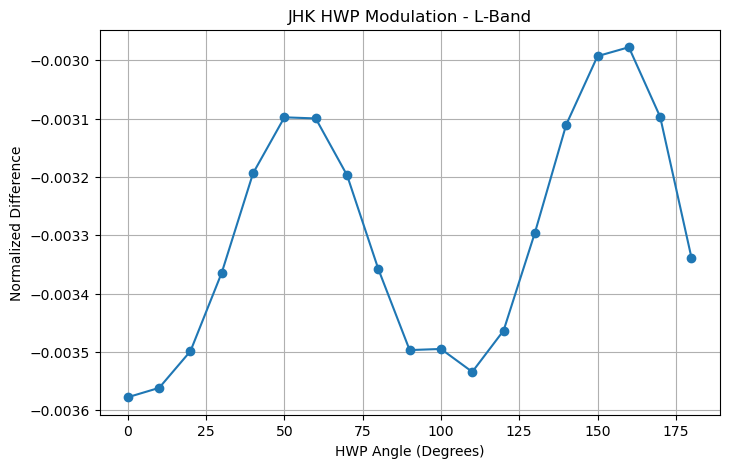

Plot saved to 20251203_L-Band_normalized_difference_vs_angle.png


<Figure size 640x480 with 0 Axes>

In [28]:
angles = np.arange(start_ang, stop_ang+1, step_ang) 
n_angles = len(angles)
n_files = len(top_fluxes)
if n_angles != n_files:
    print(f'Warning: number of angles ({n_angles}) != number of files ({n_files}). Using min length.')
L = min(n_angles, n_files)
angles = angles[:L]
top = top_fluxes[:L]
bot = bottom_fluxes[:L]

# Avoid division by zero
den = top + bot
with np.errstate(divide='ignore', invalid='ignore'):
    norm_diff = (top - bot) / den

plt.figure(figsize=(8,5))
plt.plot(angles, norm_diff, marker='o')
plt.xlabel('HWP Angle (Degrees)')
plt.ylabel("Normalized Difference")
plt.grid(True)
plt.title("JHK HWP Modulation - " + wavelength + "-Band")
plt.show()

# Save plot
plt.savefig("{}_{}-Band_normalized_difference_vs_angle.png".format(obs_date, wavelength), dpi=200)
print("Plot saved to {}_{}-Band_normalized_difference_vs_angle.png".format(obs_date, wavelength))

## Fitting for Fast Axis

In [29]:
import numpy as np
import scipy.optimize

def fit_sum_of_sines(tt, yy, num_sines=2):
    '''Fit a sum of sine waves to the input time sequence. Returns fitting parameters and a fit function.'''
    tt = np.array(tt)
    yy = np.array(yy)

    # FFT to estimate dominant frequencies
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))  # frequency bins
    Fyy = abs(np.fft.fft(yy))
    
    # Get top N frequency guesses (skip zero freq)
    top_indices = np.argsort(Fyy[1:])[::-1][:num_sines] + 1
    guess_freqs = abs(ff[top_indices])

    guess = []
    for freq in guess_freqs:
        amp = np.std(yy) / num_sines * 2.**0.5
        phase = 0.
        guess += [amp, 2.*np.pi*freq, phase]
    
    # Offset guess
    offset_guess = np.mean(yy)
    guess.append(offset_guess)

    # Define the sum-of-sines model
    def sum_of_sines(t, *params):
        result = np.zeros_like(t)
        for i in range(num_sines):
            A = params[3*i]
            w = params[3*i+1]
            p = params[3*i+2]
            result += A * np.sin(w * t + p)
        result += params[-1]  # offset
        return result

    # Fit
    popt, pcov = scipy.optimize.curve_fit(sum_of_sines, tt, yy, p0=guess, maxfev=10000)

    # Extract parameters
    sines = []
    for i in range(num_sines):
        A, w, p = popt[3*i:3*i+3]
        f = w / (2. * np.pi)
        sines.append({
            "amp": A,
            "omega": w,
            "phase": p,
            "freq": f,
            "period": 1./f
        })
    offset = popt[-1]

    # Fitted function
    fitfunc = lambda t: sum(A * np.sin(w * t + p) for A, w, p in zip(popt[::3], popt[1::3], popt[2::3])) + offset

    return {
        "sines": sines,
        "offset": offset,
        "fitfunc": fitfunc,
        "maxcov": np.max(np.abs(pcov)),
        "rawres": (guess, popt, pcov)
    }


In [30]:
res = fit_sum_of_sines(angles, norm_diff,num_sines=2)
smooth_angs = np.linspace(start_ang,stop_ang,200)
best_fit_sin = res["fitfunc"](smooth_angs)


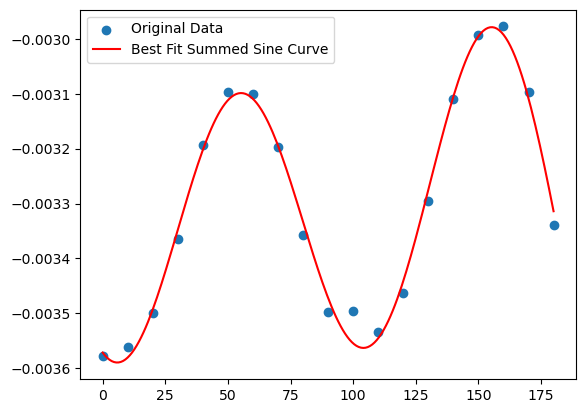

In [31]:
import matplotlib.pyplot as plt

plt.scatter(angles, norm_diff, label='Original Data')
plt.plot(smooth_angs, best_fit_sin, color='red', label='Best Fit Summed Sine Curve')
plt.legend()
plt.show()

In [32]:
from scipy.signal import find_peaks
peaks, props = find_peaks(best_fit_sin)
peak_angs = smooth_angs[peaks]
print(peaks)

[ 61 172]


In [33]:
max_peak = peak_angs[np.where(np.max(best_fit_sin[peaks]) == best_fit_sin[peaks])]
second_peak = peak_angs[np.where(np.min(best_fit_sin[peaks]) == best_fit_sin[peaks])]
print('Maximum normalized difference: '+ str(np.round(np.max(best_fit_sin[peaks]),5))+ ' at angle ' + str(np.round(max_peak[0],2)) + ' degrees')
print('Second Peak: ' + str(np.round(np.min(best_fit_sin[peaks]),5))+ ' at angle ' + str(np.round(second_peak[0],2)) + ' degrees')

Maximum normalized difference: -0.00298 at angle 155.58 degrees
Second Peak: -0.0031 at angle 55.18 degrees
